## Load, Clean, Prepare the Data

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# Fix the Seeds
SEED = 101
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import pandas as pd

# Set the Batch Size
batch_size = 64

# Set the Epochs #
epochs = 100

# Latent Dimensionality of the Encoding Space
latent_dim = 256

# # of Samples to Use
num_samples = 10000

# Data File
text = "/content/deu-eng.txt"

In [4]:
# Obtain the Features (Input) & Labels (Target)
input_texts = []
target_texts = []

# Unique Characters in the Inputs & Targets
input_characters = set()
target_characters = set()

# Load the Data into Memory
with open(text, "r", encoding = "utf-8") as f:
  lines = f.read().split("\n")

# Process Line by Line
for line in lines[: min(num_samples, len(lines) - 1)]:
  # Data Format English + TAB + The Other Language + TAB + Attribution
  # It Returns: English, The Other Language, & Attribution, Which is Discarded
  input_text, target_text, _ = line.split("\t")

  # We Use "TAB" as the "Start Sequence" Character
  # For the Targets, & "\n" as "End Sequence" Character
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)

  #Get the Unique Char from the Input Characters
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)

  #Get the Unique Char from the Target Characters
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

## Develop Encoder & Decoder for the Model

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(f"# of Samples: {len(input_texts)}")
print(f"# of Unique Input Tokens: {num_encoder_tokens}")
print(f"# of Unique Output Tokens: {num_decoder_tokens}")
print(f"Max Sequence Length for Inputs: {max_encoder_seq_length}")
print(f"Max Sequence Length for Outputs: {max_decoder_seq_length}")

# of Samples: 10000
# of Unique Input Tokens: 71
# of Unique Output Tokens: 85
Max Sequence Length for Inputs: 15
Max Sequence Length for Outputs: 45


In [6]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [7]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '9': 18,
 ':': 19,
 '?': 20,
 'A': 21,
 'B': 22,
 'C': 23,
 'D': 24,
 'E': 25,
 'F': 26,
 'G': 27,
 'H': 28,
 'I': 29,
 'J': 30,
 'K': 31,
 'L': 32,
 'M': 33,
 'N': 34,
 'O': 35,
 'P': 36,
 'Q': 37,
 'R': 38,
 'S': 39,
 'T': 40,
 'U': 41,
 'V': 42,
 'W': 43,
 'Y': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'd': 48,
 'e': 49,
 'f': 50,
 'g': 51,
 'h': 52,
 'i': 53,
 'j': 54,
 'k': 55,
 'l': 56,
 'm': 57,
 'n': 58,
 'o': 59,
 'p': 60,
 'q': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70}

In [8]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '%': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19,
 ':': 20,
 '?': 21,
 'A': 22,
 'B': 23,
 'C': 24,
 'D': 25,
 'E': 26,
 'F': 27,
 'G': 28,
 'H': 29,
 'I': 30,
 'J': 31,
 'K': 32,
 'L': 33,
 'M': 34,
 'N': 35,
 'O': 36,
 'P': 37,
 'Q': 38,
 'R': 39,
 'S': 40,
 'T': 41,
 'U': 42,
 'V': 43,
 'W': 44,
 'Y': 45,
 'Z': 46,
 'a': 47,
 'b': 48,
 'c': 49,
 'd': 50,
 'e': 51,
 'f': 52,
 'g': 53,
 'h': 54,
 'i': 55,
 'j': 56,
 'k': 57,
 'l': 58,
 'm': 59,
 'n': 60,
 'o': 61,
 'p': 62,
 'q': 63,
 'r': 64,
 's': 65,
 't': 66,
 'u': 67,
 'v': 68,
 'w': 69,
 'x': 70,
 'y': 71,
 'z': 72,
 '\xa0': 73,
 'Ä': 74,
 'Ö': 75,
 'Ü': 76,
 'ß': 77,
 'ä': 78,
 'ö': 79,
 'ü': 80,
 '’': 81,
 '“': 82,
 '„': 83,
 '\u202f': 84}

In [9]:
# Initialize the 3D Matrix
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Convert the Input Texts & Target Texts to Numerical Values
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    # Convert Input Texts to Numerical Values
    for t, char in enumerate(input_text):
      encoder_input_data[i, t, input_token_index[char]] = 1.0

    # Pad the Remaining Using Space that is Mapped to 1
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # Convert Target Texts to Numerical Values
    for t, char in enumerate(target_text):

        # Decoder Input is used to Forecast Decoder Target
        # Decoder_Target_Data is ahead of Decoder_Input_Data by One Timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # Decoder_Target_Data will be ahead by One Timestep & will not include the Start Character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

    # Pad the Remaining using Space that is Mapped to 1
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [10]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [11]:
decoder_input_data

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [12]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

## Build the Sequence to Inference Model

In [13]:
## Begin Define the encoder layers
# Define an input sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# Define the LSTM which will return the hidden states
encoder = keras.layers.LSTM(latent_dim, return_state=True)

# Apply LSTM and return the outputs and hidden states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Discard the outputs and only keep the states.
encoder_states = [state_h, state_c]
## End Define the encoder layers


## Begin Define the decoder layers
# Define the decoder inputs
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# Set up the decoder, using `encoder_states` as initial state.
# Kee the outputs and discard the hidden states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Forecast he decoder outputs using a classifier based on the decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

## End Define the decoder layers
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train the Model

In [14]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [15]:
%%time
from tensorflow.keras.callbacks import EarlyStopping
# Setup early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.001,
    mode='max'
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 45s 334ms/step - loss: 1.5863 - accuracy: 0.6360 - val_loss: 1.4853 - val_accuracy: 0.6049
Epoch 2/100
125/125 [==============================] - 41s 326ms/step - loss: 1.2192 - accuracy: 0.6653 - val_loss: 1.2717 - val_accuracy: 0.6410
Epoch 3/100
125/125 [==============================] - 41s 328ms/step - loss: 1.0381 - accuracy: 0.7185 - val_loss: 1.0463 - val_accuracy: 0.7154
Epoch 4/100
125/125 [==============================] - 40s 317ms/step - loss: 0.9021 - accuracy: 0.7514 - val_loss: 0.9482 - val_accuracy: 0.7344
Epoch 5/100
125/125 [==============================] - 43s 343ms/step - loss: 0.8174 - accuracy: 0.7703 - val_loss: 0.8937 - val_accuracy: 0.7494
Epoch 6/100
125/125 [==============================] - 42s 335ms/step - loss: 0.7667 - accuracy: 0.7823 - val_loss: 0.8662 - val_accuracy: 0.7588
Epoch 7/100
125/125 [==============================] - 41s 328ms/step - loss: 0.7300 - accuracy: 0.7901 - val_loss: 0.8176 -

## Evaluate & Fit the Model

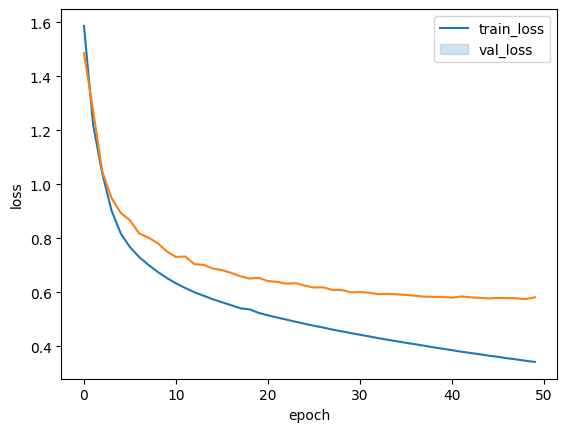

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)

# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)

# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

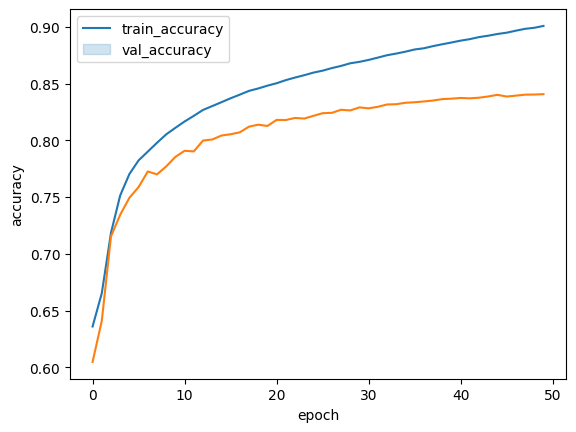

In [17]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)

# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)

# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## Run the Inference

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 71)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 85)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                335872    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

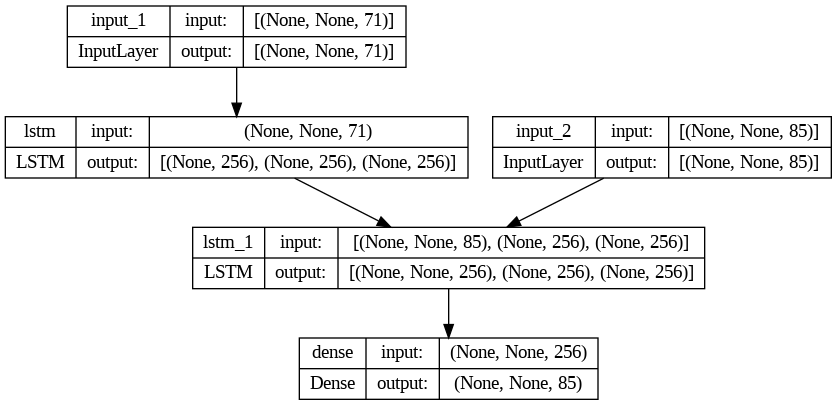

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.layers

In [21]:
model.input

[<KerasTensor: shape=(None, None, 71) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, 85) dtype=float32 (created by layer 'input_2')>]